<a href="https://colab.research.google.com/github/Vivek-Hiremath55/FakeNewsDetection/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  #I uploaded the data to my drive
drive.mount('/content/drive')   #linking drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image

import requests
from io import BytesIO

In [ ]:
training_file_path = "/content/drive/MyDrive/multimodal_train.tsv/multimodal_train.tsv"
validation_file_path = "/content/drive/MyDrive/multimodal_validate.tsv/multimodal_validate.tsv"

In [ ]:
training_df = pd.read_csv(training_file_path, sep = '\t')
validation_df = pd.read_csv(training_file_path, sep = '\t')

In [ ]:
training_df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [ ]:
print("Training Data shape:", training_df.shape)
print("Validation Data shape:", validation_df.shape)
print("\nColumns:", training_df.columns.tolist())

Training Data shape: (564000, 16)
Validation Data shape: (564000, 16)

Columns: ['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']


In [ ]:
#concatinating both train & validation set and will evaluate the data
full_df = pd.concat([training_df, validation_df], ignore_index=True)

missing_counts = full_df.isna().sum() #All missing values in teh dataset (train + val)


#Inspecting modalities (text / image / metadata)
has_text = full_df['title'].notna()
has_image = full_df['image_url'].notna()


In [ ]:
print("\nMissing values per column:\n", missing_counts) #missing values per column


Missing values per column:
 author                   57420
clean_title                  0
created_utc                  0
domain                  335714
hasImage                     0
id                           0
image_url                 3068
linked_submission_id    792286
num_comments            335714
score                        0
subreddit                    0
title                        0
upvote_ratio            335714
2_way_label                  0
3_way_label                  0
6_way_label                  0
dtype: int64


In [ ]:
print("Total examples :", len(full_df))   #total no. of samples
print("Has Text Only :", (full_df.shape[0] - (has_image).sum()))    #Samples with only text
print("Has Image Only :", (full_df.shape[0] - (has_text).sum()))    #samples with only images

print("Multi-modal / Has both text & images :", ((has_text) & (has_image)).sum())   #samples with both text and images


print("Missing both image n text:", ((~has_text) & (~has_image)).sum())   #samples missing both text and image

Total examples : 1128000
Has Text Only : 3068
Has Image Only : 0
Multi-modal / Has both text & images : 1124932
Missing both image n text: 0


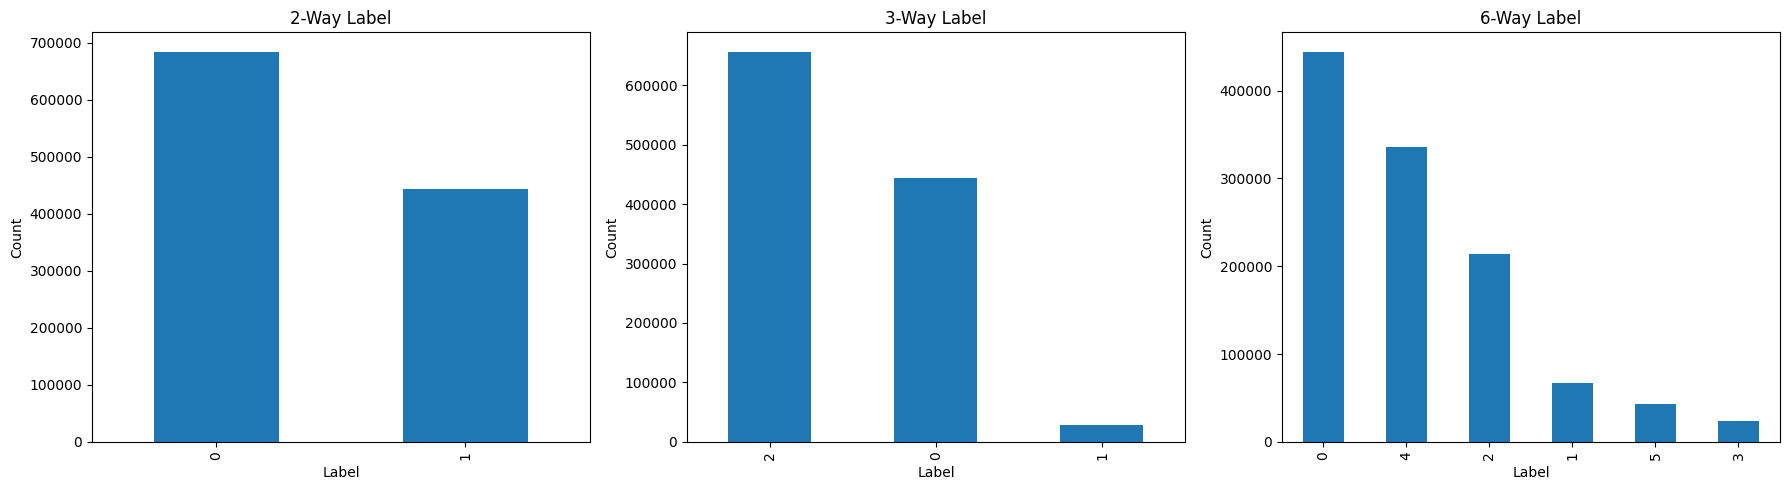

In [ ]:
#looking at class distributions

fig, axs = plt.subplots(1, 3, figsize=(18, 5))    #figure with 3 plots (each type og class representation)

for ax, col, title in zip(
    axs,
    ['2_way_label','3_way_label','6_way_label'],
    ['2-Way Label','3-Way Label','6-Way Label']
):
    full_df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Title: The Eden Fruits - Skinless
2-way label: 0


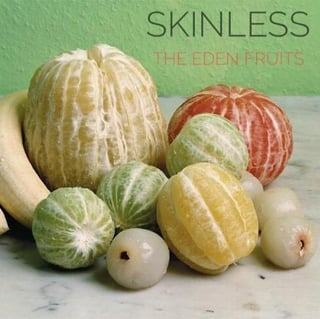

--------------------------------------------------
Title: Broke my iPad screen :(
2-way label: 0


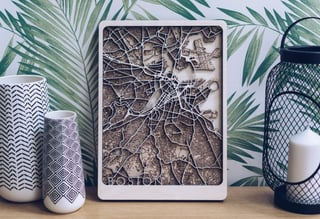

--------------------------------------------------
Title: [Biology] Are there tangible differences in elements come from?
2-way label: 0


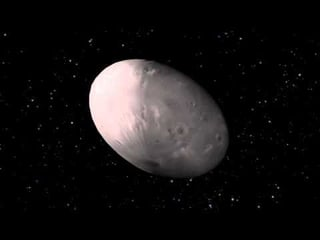

--------------------------------------------------
Title: With all the Syria drama, I present some propaganda posters of the regime found online.
2-way label: 0


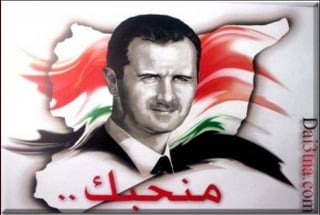

--------------------------------------------------
Title: Photogenic Banana
2-way label: 1


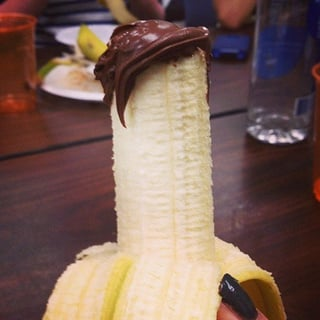

--------------------------------------------------


In [ ]:
sample_set = full_df.dropna(subset=['image_url', 'title']).sample(5, random_state=42)   #cause we already saw that
                                                                                    #imagecolumn is missing some entrues

for _, row in sample_set.iterrows():    #iterating through those 5 random selections we made above
    print("Title:", row['title'])
    print("2-way label:", row['2_way_label'])
    try:    #try catch block for cases where the image is not accessible or unavailable now
        response = requests.get(row['image_url'], timeout=5)    #extracting image from the url (url column)
        img = Image.open(BytesIO(response.content))
        display(img)
    except:
        print("Unable to lod image")
    print("-" * 50)


## Text analysis

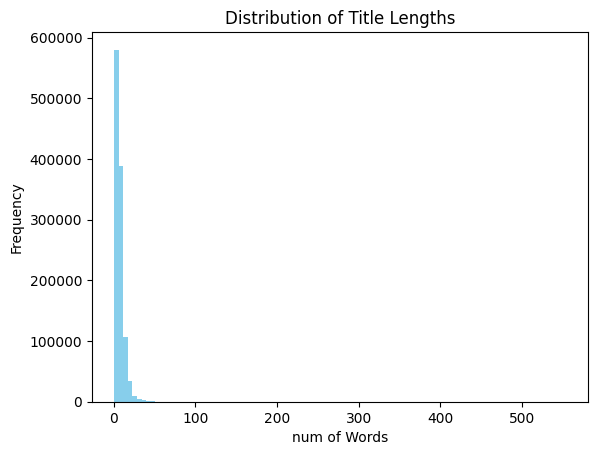

In [ ]:
#looking at the lengths of the titles

#the dataset alreadt has a clean title column (no stop words)
full_df['title_len'] = full_df['clean_title'].apply(lambda x: len(x.split()))#a new column for title length

plt.hist(full_df['title_len'], bins=100, color='skyblue')#
plt.title('Distribution of Title Lengths')
plt.xlabel('num of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from wordcloud import WordCloud

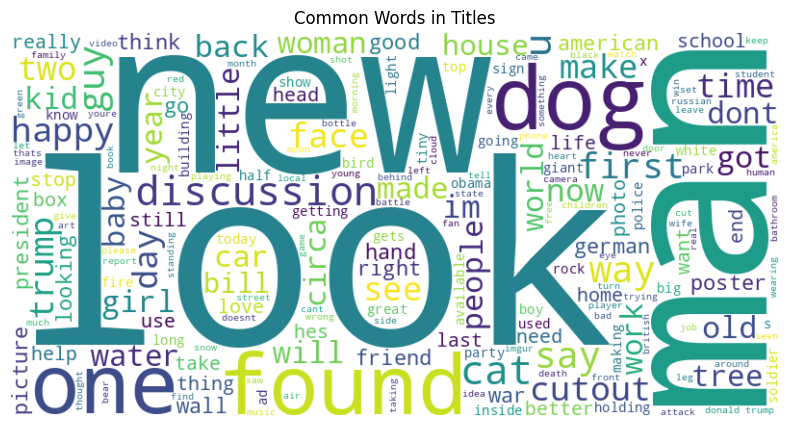

In [ ]:
#making a word cloud from clean titles (using 5000 samples to prevent memory overload)

sample_text = " ".join(full_df['clean_title'].sample(5000, random_state=42)) #selecting 5000 sampels at random
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Titles")
plt.show()

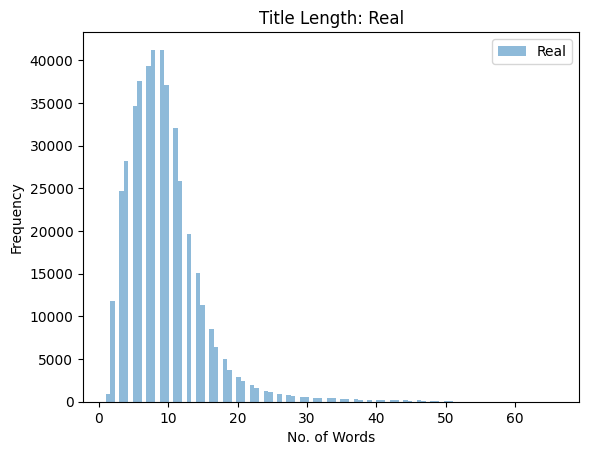

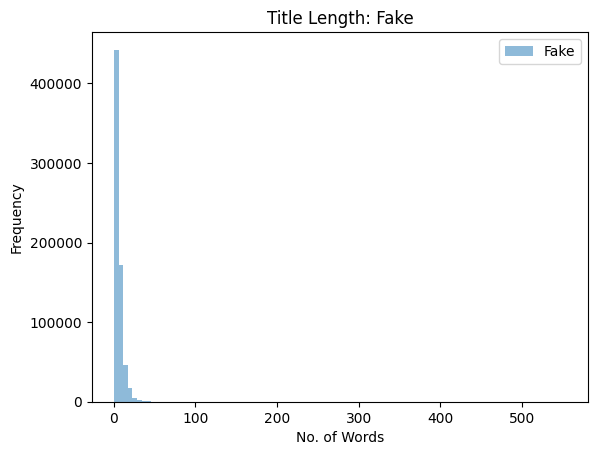

In [ ]:
#comparing length of real titles against length fake titles

real_len = full_df.loc[full_df['2_way_label']==1, 'text_len']
fake_len = full_df.loc[full_df['2_way_label']==0, 'text_len']

#distribution of lengths of real titles
plt.hist(real_len, bins=100, alpha=0.5, label='Real')
plt.legend()
plt.title("Title Length: Real")
plt.xlabel("No. of Words")
plt.ylabel("Frequency")
plt.show()

#distribution of lengths of fake titles
plt.hist(fake_len, bins=100, alpha=0.5, label='Fake')
plt.legend()
plt.title("Title Length: Fake")
plt.xlabel("No. of Words")
plt.ylabel("Frequency")
plt.show()


## Image analysis

In [ ]:
import cv2

In [ ]:
def image_analysis(url):
  """
  Function operation -> Using the url to access the image and extract its dimensions & average brightness
                        if the image is found, else returns nan for all these values
  Input -> ulr string from the url column in the dataset
  Output -> width, height and brightness of the image
  """
  try:
      r = requests.get(url, timeout=5)
      img = Image.open(BytesIO(r.content)).convert('RGB')
      arr = np.array(img)
      h, w, _ = arr.shape
      brightness = arr.mean()
      return [w, h, brightness]
  except:
      return np.nan, np.nan, np.nan

In [ ]:
#using randomly selected 500 images
image_sample_set = full_df.dropna(subset=['image_url']).sample(500, random_state=42)

In [ ]:
image_stats = image_sample_set['image_url'].apply(image_analysis) #list of list (details)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Created and populated lists
width_list = []
height_list = []
brightness_list = []


for entry, stats in enumerate(image_stats):
  width_list.append(stats[0])
  height_list.append(stats[1])
  brightness_list.append(stats[2])

In [ ]:
column_addition_list = ['width', 'height', 'brightness']

image_sample_set['width'] = width_list
image_sample_set['height'] = height_list
image_sample_set['brightness'] = brightness_list

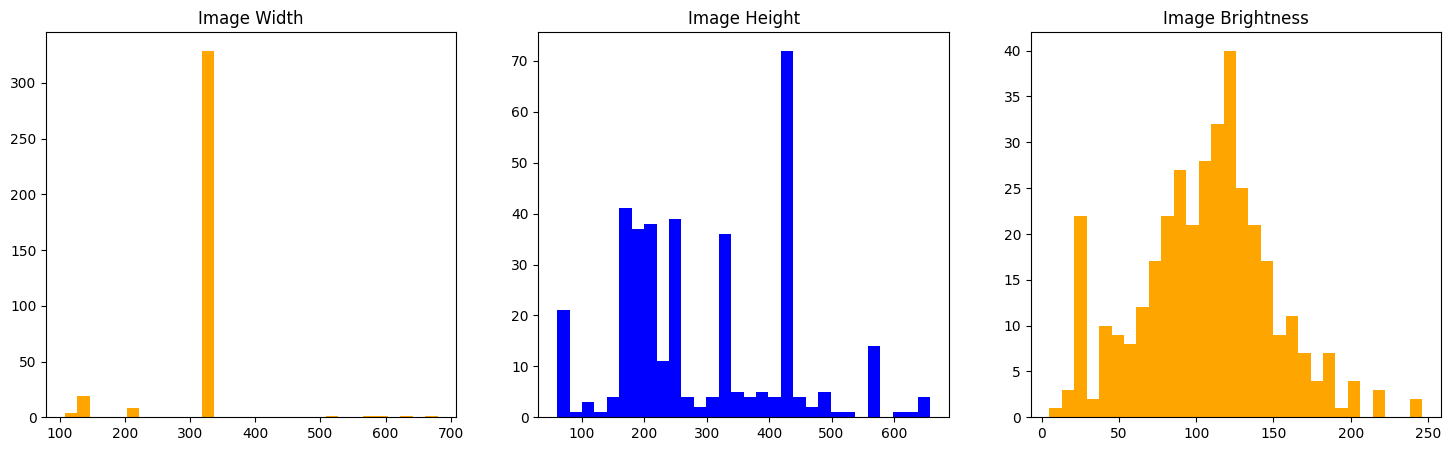

In [ ]:
#plotting distibutions for each parameter we extracted
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].hist(image_sample_set['width'], bins=30, color='orange')
axs[0].set_title("Image Width")

axs[1].hist(image_sample_set['height'], bins=30, color='blue')
axs[1].set_title("Image Height")

axs[2].hist(image_sample_set['brightness'], bins=30, color='orange')
axs[2].set_title("Image Brightness")

plt.show()


# Phase 2 - Benchmarking

In [ ]:
from google.colab import drive  #I uploaded the data to my drive
drive.mount('/content/drive')   #linking drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image

import requests
from io import BytesIO

In [ ]:
training_file_path = "/content/drive/MyDrive/multimodal_train.tsv/multimodal_train.tsv"
validation_file_path = "/content/drive/MyDrive/multimodal_validate.tsv/multimodal_validate.tsv"

In [ ]:
training_df = pd.read_csv(training_file_path, sep = '\t')
validation_df = pd.read_csv(training_file_path, sep = '\t')

In [ ]:
#concatinating both train & validation set and will evaluate the data
full_df = pd.concat([training_df, validation_df], ignore_index=True)

### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_small = full_df.dropna(subset=['clean_title', 'image_url']) #Dropping entries that are missing either the title or the url

In [ ]:
df_small.shape

(1124932, 16)

In [ ]:
df_small, _ = train_test_split(df_small,
                               stratify=df_small['2_way_label'],    #applying stratified train test splut on target = 2_way_label
                               test_size=0.9997,                   #selecting only ~300 samples from the data
                               random_state=42)

print(df_small['2_way_label'].value_counts(normalize=True))

2_way_label
0    0.608309
1    0.391691
Name: proportion, dtype: float64


In [ ]:
df_small.shape

(337, 16)

60% of data has label 0 and 40% has 1 (so the data split for both classes is fair enough even if not equally represented)

### Train test split - These sets would be used to train and evaluate all the models (baseline text, baseline image and SOTA architecture)

In [ ]:
df_small_train, df_small_test = train_test_split(df_small,
                               stratify=df_small['2_way_label'],    #applying stratified train test splut on target = 2_way_label
                               test_size=0.2,                   #normal 80 / 20 split
                               random_state=42)

In [ ]:
df_small_train.shape

(269, 16)

In [ ]:
print(df_small_train['2_way_label'].value_counts(normalize=True))

2_way_label
0    0.609665
1    0.390335
Name: proportion, dtype: float64


## Baseline Model

### 1. Benchmarking for a Baseline Text only Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
#Applying TF-IDF (the words too frequent and common in every document would be considered low importance)
#But those frequent and present in very few documents would still stay relevant

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = vectorizer.fit_transform(df_small_train['clean_title'])
y = df_small_train['2_way_label']   #target


X_train, X_test, y_train, y_test = train_test_split(X_text, y, stratify=y, test_size=0.2, random_state=42)  #train validation set split


clf_text_only = LogisticRegression(max_iter=200)      #training logisticc regression model
clf_text_only.fit(X_train, y_train)


y_pred = clf_text_only.predict(X_test)          #predictions & classigcation report()
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76        33
           1       0.00      0.00      0.00        21

    accuracy                           0.61        54
   macro avg       0.31      0.50      0.38        54
weighted avg       0.37      0.61      0.46        54



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Observation : The model ended up predicting every sample in validation set as 0 which resulted in the metrics being 0 for **label 1**. This shows that the model is unable to predict properly and instead sticks to the majority class to minimize error.

#### Potential reasons : Since we have to evaluate the performance of all 3 models I've decided to use the same train / validation and test set for each of the models (small sets cause hardware limitations for image preprocessing). But it is very likely that the smaller size of the training set contributed to the inability of the **text only** model to predict labels properly.

## 2. Benchmarking for a Baseline Image only Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import random

In [ ]:
transform = transforms.Compose([    # transformer to convert all the images to single size (CNN friendly so kernel )
    transforms.Resize((128, 128)),  #using the smallest size (would experiment if the results aren't satisfactory - information retention)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):

    """
    function operation - Takes in the pandas dataframe and extracts the 2 way labels and images from the url. Then it transforms the images retrieved
                         from the url into a set format for consistency in the CNN (image vector has to be a single size)
    Input - Pandas dataframe
    Output - transformed image and the label is returned
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        url = self.df.iloc[idx]['image_url']
        label = int(self.df.iloc[idx]['2_way_label'])
        try:
            response = requests.get(url, timeout=5)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except:
            image = Image.new("RGB", (128, 128))    #fi the image cannot be loaded, this would throw a blacked-out iage (dummy image)

        if self.transform:
            image = self.transform(image)
        return image, label


dataset = ImageDataset(df_small_train, transform)     #creating a dataset of the transformed images
loader = DataLoader(dataset, batch_size=16, shuffle=False)    #forming the dataloafer to iterate through each on of the images and labels


device = "cuda" if torch.cuda.is_available() else "cpu"   #looking for gpu availability
mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)    #I'm using mobilenet because it is a relatively small nodel and the inference time is low
mobilenet.classifier[1] = nn.Identity()  #removing the classification layer (I only want to use the model to extract the image features)
mobilenet.eval().to(device)   #loading model to device

features_list, labels_list = [], []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)    #loading images to cpu / gpu
        feats = mobilenet(imgs)  #using mobilenet to extract image features
        features_list.append(feats.cpu().numpy())   #this list will be the feature list that will be fed to the logistic regression
        labels_list.append(labels.numpy())          #label list for the logistic regression model

X_img = np.concatenate(features_list, axis=0)
y_img = np.concatenate(labels_list, axis=0)

print("Feature shape:", X_img.shape)


X_train, X_test, y_train, y_test = train_test_split(      #train test split (stratifying)
    X_img, y_img, stratify=y_img, test_size=0.2, random_state=42
)

clf_image_only = LogisticRegression(max_iter=300)    #using the extracted image features as the input for logistice regression model
clf_image_only.fit(X_train, y_train)


y_pred = clf_image_only.predict(X_test)
print("\nImage-Only Baseline Performance:\n")
print(classification_report(y_test, y_pred))


Feature shape: (269, 1280)

Image-Only Baseline Performance:

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        33
           1       0.61      0.67      0.64        21

    accuracy                           0.70        54
   macro avg       0.69      0.70      0.69        54
weighted avg       0.71      0.70      0.71        54



### Benchmarking for a SOTA architecture (CLIP)

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install pillow requests tqdm scikit-learn


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wc7icyii
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wc7icyii
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import clip
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm


from sklearn.model_selection import train_test_split


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


image_features = []
text_features = []

for idx, row in tqdm(df_small_train.iterrows(), total=len(df_small_train)):
    # Encoding images
    try:
        response = requests.get(row['image_url'], timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image = image.resize((224, 224))  # faster processing
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = model.encode_image(image_input).cpu().numpy().flatten()
    except:
        img_feat = np.zeros((512,))  # fallback if image fails
    image_features.append(img_feat)

    # Encoding text
    text_input = clip.tokenize([row['clean_title']]).to(device)
    with torch.no_grad():
        txt_feat = model.encode_text(text_input).cpu().numpy().flatten()
    text_features.append(txt_feat)


X_clip = np.hstack([image_features, text_features])
y_clip = df_small_train['2_way_label'].values


X_train, X_test, y_train, y_test = train_test_split(
    X_clip, y_clip, stratify=y_clip, test_size=0.2, random_state=42
)


clf_clip = LogisticRegression(max_iter=300)
clf_clip.fit(X_train, y_train)


y_pred = clf_clip.predict(X_test)
print("\n",classification_report(y_test, y_pred))


100%|██████████| 269/269 [02:15<00:00,  1.99it/s]


               precision    recall  f1-score   support

           0       0.85      0.88      0.87        33
           1       0.80      0.76      0.78        21

    accuracy                           0.83        54
   macro avg       0.83      0.82      0.82        54
weighted avg       0.83      0.83      0.83        54



# Evaluation :
1. Text Only Model
2. Image Only Model
3. CLIP architecture (Text + Image)

Each of these model was trained and validated on the same sets and now will be tested on the same test set. This result will be used for the final conclusion of the report for this phase (Baseline for each architecture).

#### Text Only Model evaluation

In [ ]:
mX_test = vectorizer.transform(df_small_test['clean_title']) #preprocessing
y = df_small_test['2_way_label']   #target

y_pred = clf_text_only.predict(X_test)          #predictions & classifcation report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.95      0.74        41
           1       0.33      0.04      0.07        27

    accuracy                           0.59        68
   macro avg       0.47      0.49      0.40        68
weighted avg       0.49      0.59      0.47        68



#### Image Only Model evaluation

In [ ]:
dataset_test = ImageDataset(df_small_test, transform)     #preprocessing
loader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)    #loader


#device = "cuda" if torch.cuda.is_available() else "cpu"
#mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
#mobilenet.classifier[1] = nn.Identity()
#mobilenet.eval().to(device)

features_list_test, labels_list_test = [], []

with torch.no_grad():
    for imgs, labels in loader_test:
        imgs = imgs.to(device)
        feats = mobilenet(imgs) #using the same mobilenet model we used before for image feature extraction
        features_list_test.append(feats.cpu().numpy())
        labels_list_test.append(labels.numpy())

X_img = np.concatenate(features_list_test, axis=0)
y_img = np.concatenate(labels_list_test, axis=0)


y_pred = clf_image_only.predict(X_img)
print("\nImage-Only Baseline Performance:\n")
print(classification_report(y_img, y_pred))


Image-Only Baseline Performance:

              precision    recall  f1-score   support

           0       0.76      0.71      0.73        41
           1       0.60      0.67      0.63        27

    accuracy                           0.69        68
   macro avg       0.68      0.69      0.68        68
weighted avg       0.70      0.69      0.69        68



#### CLIP evaluation

In [ ]:
image_features_test = []
text_features_test = []

for idx, row in tqdm(df_small_test.iterrows(), total=len(df_small_test)):
    # Encoding images
    try:
        response = requests.get(row['image_url'], timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image = image.resize((224, 224))  # faster processing
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            img_feat = model.encode_image(image_input).cpu().numpy().flatten()
    except:
        img_feat = np.zeros((512,))  # fallback if image fails
    image_features_test.append(img_feat)

    # Encoding text
    text_input = clip.tokenize([row['clean_title']]).to(device)
    with torch.no_grad():
        txt_feat = model.encode_text(text_input).cpu().numpy().flatten()
    text_features_test.append(txt_feat)


X_clip_test = np.hstack([image_features_test, text_features_test])
y_clip_test = df_small_test['2_way_label'].values


y_pred = clf_clip.predict(X_clip_test)
print("\n",classification_report(y_clip_test, y_pred))

100%|██████████| 68/68 [00:38<00:00,  1.75it/s]


               precision    recall  f1-score   support

           0       0.80      0.80      0.80        41
           1       0.70      0.70      0.70        27

    accuracy                           0.76        68
   macro avg       0.75      0.75      0.75        68
weighted avg       0.76      0.76      0.76        68



## Observations for Evaluation

1. The multi-modal architecture produced the best results on the unseen data
2. Image only model produced decent results too. However, the text only model struggles with predictions.

Learning - Multi-modal architecture encodes both the image and text into a single subspace which helps bridging the gaps between these 2 mode of information. Basically somehwat giving it the understanding of semantic relationship between image and text..

Note - The failure of text only model can to an extent be attributed to the small dataset (which I selected due to lack of adequate hardware to process all images)

# PART 3: DEVELOPMENT OF WON METHOD

# Problem statement & Arch Justification:


The goal of this project is to build a multimodal classifier that predicts whether image–text pairs are semantically consistent. Each sample is represented by a fused feature vector combining CLIP-derived image and text embeddings, along with optional interaction features such as absolute differences and element-wise products. The classifier is a single Multi-Layer Perceptron (MLP) with two hidden layers, ReLU activations, and dropout regularization. This design allows the network to learn nonlinear relationships between modalities efficiently while keeping the model lightweight and less prone to overfitting. Early fusion of features ensures cross-modal interactions are captured directly, and the use of pretrained CLIP embeddings leverages rich semantic representations for both images and text.

In [ ]:
from google.colab import drive  #I uploaded the data to my drive
drive.mount('/content/drive')   #linking drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image

import requests
from io import BytesIO

In [ ]:
training_file_path = "/content/drive/MyDrive/multimodal_train.tsv/multimodal_train.tsv"
validation_file_path = "/content/drive/MyDrive/multimodal_validate.tsv/multimodal_validate.tsv"

In [ ]:
training_df = pd.read_csv(training_file_path, sep = '\t')
validation_df = pd.read_csv(training_file_path, sep = '\t')

In [ ]:
#concatinating both train & validation set and will evaluate the data
full_df = pd.concat([training_df, validation_df], ignore_index=True)

### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_small = full_df.dropna(subset=['clean_title', 'image_url']) #Dropping entries that are missing either the title or the url

In [ ]:
df_small.shape

(1124932, 16)

In [ ]:
df_small, _ = train_test_split(df_small,
                               stratify=df_small['2_way_label'],    #applying stratified train test splut on target = 2_way_label
                               test_size=0.9997,                   #selecting only ~300 samples from the data
                               random_state=42)

print(df_small['2_way_label'].value_counts(normalize=True))

2_way_label
0    0.608309
1    0.391691
Name: proportion, dtype: float64


In [ ]:
df_small.shape

(337, 16)

60% of data has label 0 and 40% has 1 (so the data split for both classes is fair enough even if not equally represented)

### Train test split - These sets would be used to train and evaluate all the models (my own method)

In [ ]:
df_small_train, df_small_test = train_test_split(df_small,
                               stratify=df_small['2_way_label'],    #applying stratified train test splut on target = 2_way_label
                               test_size=0.2,                   #normal 80 / 20 split
                               random_state=42)

In [ ]:
df_small_train.shape

(269, 16)

In [ ]:
print(df_small_train['2_way_label'].value_counts(normalize=True))

2_way_label
0    0.609665
1    0.390335
Name: proportion, dtype: float64


In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install pillow requests tqdm scikit-learn


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5o8_8xm9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5o8_8xm9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


### Required libraries

In [ ]:
import os, random, numpy as np, torch, torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO
import clip

#### Setting up for reproucibility

In [ ]:
#Reproducibility to make sure training runs the same way each time.

SEED = 42   #setting random seed
random.seed(SEED); np.random.seed(SEED) #setting the same random seed
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
#os.environ["PYTHONHASHSEED"] = str(SEED)

CFG = {                      #storing the model paramters in a dictionary
    "clip_model": "ViT-B/32",
    "val_size": 0.20,
    "epochs": 12,            # this script WILL run all epochs (no early stopping)
    "lr": 5e-4,
    "weight_decay": 1e-4,
    "hidden_dim": 512,
    "dropout": 0.30,
    "feature_rich": True,    # True => [img, txt, |diff|, prod], False => [img, txt]
    "timeout": 5,            # seconds for image fetch
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_classes": 2,
}

device = CFG["device"]
clip_model, preprocess = clip.load(CFG["clip_model"], device=device)
clip_model.eval()
print("Device:", device, "| CLIP:", CFG["clip_model"])

Device: cpu | CLIP: ViT-B/32


#### Encoding the image and the text using CLIP

In [ ]:
def encode_image_text_clip(row, model, preprocess, device="cpu", timeout=5, emb_dim=512):
    """
    Purpose - Takes each sample (row) from the dataset, extracts the title and the image.
              And then uses CLIP's architecture to encode the image and text into common sample space.

    Inputs - row = each row in the dataframe
             model = Model used to encode the image and text
             preprocessor = We use CLIP's preprocessor, but can be changed
             device = GPU / CPU (set to CPU as I'm only using CPU)
             timeout = time to wait before giving up on an image download
             embedded dimensions = expected embedding dimensions

    Output - 1. Numpy array of image embedding
             2. Numpy array of text embedding
    """
    #image encoding
    try:
        resp = requests.get(row["image_url"], timeout=timeout)
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        img = img.resize((224, 224))
        img_in = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            img_vec = model.encode_image(img_in).cpu().numpy().flatten()
    except Exception:
        img_vec = np.zeros((emb_dim,), dtype=np.float32)#if failed to download, give out black image
    #text encoding
    tok = clip.tokenize([row["clean_title"]], truncate=True).to(device)
    with torch.no_grad():
        txt_vec = model.encode_text(tok).cpu().numpy().flatten()
    return img_vec.astype(np.float32), txt_vec.astype(np.float32)

def encode_split(df, model, preprocess, device="cpu", timeout=5):
    """
    Purpose - Encodes a whole dataset split (like train or test) into image and text embeddings.

    Inputs:df - dataframe containing image URLs, text titles, and labels ("2_way_label").
               model, preprocess, device, timeout: same as before.

    Outputs - X_img - matrix of image embeddings (shape: n_samples × 512).
             X_txt - matrix of text embeddings (shape: n_samples × 512).
             y - label vector for all samples.
    """
    image_features, text_features = [], []
    y = df["2_way_label"].values
    # infer emb dim once (robust if some images fail)
    emb_dim = 512
    first_ok = True
    for _, row in tqdm(df.iterrows(), total=len(df), desc="CLIP encoding"):
        if first_ok:
            try:
                _resp = requests.get(row["image_url"], timeout=timeout)
                _img = Image.open(BytesIO(_resp.content)).convert("RGB")
                _in = preprocess(_img).unsqueeze(0).to(device)
                with torch.no_grad():
                    emb_dim = clip_model.encode_image(_in).shape[-1]
            except Exception:
                pass
            first_ok = False
        img_vec, txt_vec = encode_image_text_clip(row, model, preprocess, device, timeout, emb_dim)
        image_features.append(img_vec)
        text_features.append(txt_vec)
    return np.vstack(image_features), np.vstack(text_features), y

In [ ]:
def feature_builder(z_img, z_txt, rich=True):
    """rich=True -> [img, txt, |img-txt|, img*txt]; else -> [img, txt]."""
    if rich:
        return np.hstack([z_img, z_txt, np.abs(z_img - z_txt), z_img * z_txt])
    return np.hstack([z_img, z_txt])

#### I'm using a simple MLP

In [ ]:
class MLP(nn.Module):#multi-layer perceptron
    def __init__(self, fin, hidden=512, p=0.3, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(fin, hidden),
            nn.ReLU(), #non-linear activation (introducing the non-linear element)
            nn.Dropout(p),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden//2, num_classes) #output layer
        )
    def forward(self, x): return self.net(x)

def train_mlp(X_train, y_train, X_val, y_val, cfg, device="cpu"):
    """
    Purpose - Trains the MLP model on training data and evaluates on validation data after each epoch.

    Inputs - Train/validation features and labels.
            Config dictionary with hyperparameters.
            Device (CPU/GPU).

    Outputs - The best-performing trained MLP mode.
    """
    Xt = torch.tensor(X_train, dtype=torch.float32).to(device)
    Yt = torch.tensor(y_train, dtype=torch.long).to(device)
    Xv = torch.tensor(X_val,   dtype=torch.float32).to(device)
    Yv = torch.tensor(y_val,   dtype=torch.long).to(device)

    model = MLP(fin=Xt.shape[1], hidden=cfg["hidden_dim"], p=cfg["dropout"], num_classes=cfg["num_classes"]).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    crit = nn.CrossEntropyLoss()

    for ep in range(1, cfg["epochs"] + 1):
        model.train()
        opt.zero_grad()
        logits = model(Xt)
        loss = crit(logits, Yt)
        loss.backward()
        opt.step()

        # validation accuracy (same style as Snippet #1)
        model.eval()
        with torch.no_grad():
            preds_val = model(Xv).argmax(dim=1)
            acc = (preds_val == Yv).float().mean().item()
        print(f"Epoch {ep}/{cfg['epochs']} - Loss: {loss.item():.4f} - Val Acc: {acc:.4f}")
    return model



#### Validation report

In [ ]:
def eval_report(model, X, y, title="Report", device="cpu"):
    """
    Purpose - evaluates trained model and prints classification report

    Inputs - trained model, features, labels, title and device
    """
    Xt = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(Xt).argmax(1).cpu().numpy()
    print(f"\n{title}:\n", classification_report(y, pred, digits=4))
    print(f"Accuracy: {accuracy_score(y, pred):.4f}; Macro-F1: {f1_score(y, pred, average='macro', zero_division=0):.4f}")

### Train & validation split

In [ ]:
try:
    #encoding the train splut using CLIP's architecture
    X_img_tr_all, X_txt_tr_all, y_tr_all = encode_split(df_small_train, clip_model, preprocess, device=device, timeout=CFG["timeout"])
    #building features (adding an element of non-linearity)
    X_feat_all = feature_builder(X_img_tr_all, X_txt_tr_all, rich=CFG["feature_rich"])
    #stratified train and validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_feat_all, y_tr_all, stratify=y_tr_all, test_size=CFG["val_size"], random_state=SEED
    )
except NameError as e:
    raise RuntimeError("df_small_train not found in environment. Please provide df_small_train with "
                       "'image_url','clean_title','2_way_label' columns before running this script.") from e

CLIP encoding: 100%|██████████| 269/269 [02:15<00:00,  1.98it/s]


### Training & Validation performance

In [ ]:
#Model training and evaluation on the validation set
mlp_model = train_mlp(X_train, y_train, X_val, y_val, CFG, device=device)
eval_report(mlp_model, X_val, y_val, title="Validation", device=device)

Epoch 1/12 - Loss: 0.6884 - Val Acc: 0.6111
Epoch 2/12 - Loss: 0.6484 - Val Acc: 0.6111
Epoch 3/12 - Loss: 0.6073 - Val Acc: 0.6481
Epoch 4/12 - Loss: 0.5684 - Val Acc: 0.7778
Epoch 5/12 - Loss: 0.5221 - Val Acc: 0.7778
Epoch 6/12 - Loss: 0.4718 - Val Acc: 0.7963
Epoch 7/12 - Loss: 0.4194 - Val Acc: 0.7778
Epoch 8/12 - Loss: 0.3791 - Val Acc: 0.7963
Epoch 9/12 - Loss: 0.3216 - Val Acc: 0.7963
Epoch 10/12 - Loss: 0.2806 - Val Acc: 0.7963
Epoch 11/12 - Loss: 0.2266 - Val Acc: 0.8333
Epoch 12/12 - Loss: 0.1796 - Val Acc: 0.7778

Validation:
               precision    recall  f1-score   support

           0     0.8182    0.8182    0.8182        33
           1     0.7143    0.7143    0.7143        21

    accuracy                         0.7778        54
   macro avg     0.7662    0.7662    0.7662        54
weighted avg     0.7778    0.7778    0.7778        54

Accuracy: 0.7778; Macro-F1: 0.7662


### Testing CLIP + MLP

In [ ]:
#Model performance on test set

try:
    X_img_te, X_txt_te, y_te = encode_split(df_small_test, clip_model, preprocess, device=device, timeout=CFG["timeout"])
    X_test = feature_builder(X_img_te, X_txt_te, rich=CFG["feature_rich"])
    # If you used normalization above, transform test with scaler.transform(X_test)
    eval_report(mlp_model, X_test, y_te, title="Test", device=device)
except NameError:
    print("df_small_test not found — skipping test evaluation. Provide df_small_test to run final test eval.")

CLIP encoding: 100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


Test:
               precision    recall  f1-score   support

           0     0.7857    0.8049    0.7952        41
           1     0.6923    0.6667    0.6792        27

    accuracy                         0.7500        68
   macro avg     0.7390    0.7358    0.7372        68
weighted avg     0.7486    0.7500    0.7491        68

Accuracy: 0.7500; Macro-F1: 0.7372
